# A model of learning of the income process

This notebook experiments multiple dimensions via which agents misspecify the model of income leading to following empirical patterns of subjective income risk

- Higher realizations corresponding to lower perceived risks 
- Older age corresponds to lower uncertainty 
- Cohort-specific uncertainty depending on the past realization of the income dispersion of the group 
- Asymmetry in the effect of realization of shocks, i.e. positive shocks brings about lower uncertainty and higher reduces the uncerainty. 
- Interplay between income realizations and uncertainty, i.e. extrapolative from the first moment to the second 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
import numpy.linalg as lg
from scipy.special import erf 
import scipy.linalg as splg
import pandas as pd
from numba import njit
#from numba import int32,int64, float32,float64, types,typed,typeof

In [2]:
## figure configurations 

fontsize = 23
titlesize = 26
figsize = (10,8)
legendsize = 20
lw = 6 

In [3]:
"""
ar_paras = np.array([0.95,0.1])
typeof(ar_paras)

spec = [
    ('ar_paras',typeof(ar_paras)),  # a simple scalar field
    ('rho', float64),                       # an array field
    ('sigma', float64), 
    ('N', int32), 
    ('k', int32), 
    ('burn', float32),
    ('shock_type', types.unicode_type),
    ('shock_type_perceived', types.unicode_type),
    ('n_sim', int32), 
    ('work_age', int32), 
    ('agg_corr', float32), 
    ('corr', float32), 
    ('theta', float32)
     ]
"""

"\nar_paras = np.array([0.95,0.1])\ntypeof(ar_paras)\n\nspec = [\n    ('ar_paras',typeof(ar_paras)),  # a simple scalar field\n    ('rho', float64),                       # an array field\n    ('sigma', float64), \n    ('N', int32), \n    ('k', int32), \n    ('burn', float32),\n    ('shock_type', types.unicode_type),\n    ('shock_type_perceived', types.unicode_type),\n    ('n_sim', int32), \n    ('work_age', int32), \n    ('agg_corr', float32), \n    ('corr', float32), \n    ('theta', float32)\n     ]\n"

In [4]:
class LearningIncome:
    def __init__(self,
                 ar_paras = np.array([0.95,0.01]),
                 N = 60):
        self.ar_paras = ar_paras
        self.rho = ar_paras[0]
        self.sigma = ar_paras[1]
        self.N = N 
        self.k = 1
        self.burn = 0.2
        self.n_sim = 30
        self.shock_type = 'iid'
        self.shock_type_perceived = 'iid'
        self.work_age = 15
        self.agg_corr = 1
        self.corr = 0.9
        self.theta = 1.5
             
# simulate individual time series and cross-sectional data 

    def Simulateiid(self):
        ar1 = self.ar_paras
        rho,sigma = ar1
        N_burn = np.int(self.burn*self.N)
        N_long = self.N + N_burn
        simulated_pop = ARSimulator(rho,
                                    sigma,
                                    N_long)
        self.simulated = simulated_pop[N_burn:]
        return self.simulated 
    
    def SimulateAggCorr(self):
        ar1 = self.ar_paras
        rho,sigma = ar1
        N_burn = np.int(self.burn*self.N)
        N_long = self.N + N_burn
        sks = DrawShocks(sigma = sigma,     # size of income shock
                         agg_corr = self.agg_corr,  # cross-sectional correlation 
                         n = self.n_sim,         # nb of people each point of time
                         T = self.N)         # time period 
        simulated_pop = ARPanelSimulator(rho = rho,
                                         n = self.n_sim,
                                         T = self.N,
                                         shocks = sks)
        return simulated_pop[:,N_burn:]
        
    def SimulatePop(self):
        self.simulated_pop = np.empty([self.n_sim,self.N])
        if self.shock_type =='iid':
            for i in range(self.n_sim):
                self.simulated_pop[i,:] = self.Simulateiid()
        if self.shock_type =='correlated':
            self.simulated_pop = self.SimulateAggCorr()
            
        return self.simulated_pop
    
## learning based on a given sample 
    
    def LearnPara(self,
                  sample,
                  which = 1): 
        n_sim,N = sample.shape
        Y = np.asmatrix(sample[:,1:].flatten()).T
        X = np.asmatrix(sample[:,:-1].flatten()).T
        nobs = len(Y)
        model = sm.OLS(Y,X)
        rs = model.fit()
        #print(rs.summary())
        coeffs_est = rs.params
        self.rs_correct = rs
        self.errs = rs.resid.reshape(n_sim,N-1) ## residuals matrix 
        self.recent = sample[which,-1]
        #self.change = sample[which,-1] - sample[which,-2]
        self.change  = self.errs[which,-1]
        
        if self.shock_type_perceived == 'iid':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D = np.eye(nobs)*self.sigma**2
            self.D_est = np.eye(nobs)*self.sigma2_est
            xx = np.dot(X.T,X)
            ## regression coeffs 
            #coef_var_est0 = rs.bse**2  # using statsmodel package 
            coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
            #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
            #                                     X.T),
            #                                     self.D_est),
            #                              X),
            #                       lg.inv(xx)
            #                      )) ## by general formula 
            self.coef_var_est = coef_var_est1
            
        if self.shock_type_perceived == 'non-independence':  ## generalized least square 
            sigma_est = np.eye(nobs)
            for i in range(int(rs.nobs - N)):
                sigma_est[i,i+N]= self.corr
                sigma_est[i+N,i] = self.corr ## create correlation across people
            #sigma_est = np.where(sigma_est == 0, 
            #                     self.corr**2, 
            #                     sigma_est)  # diagnal being 1 and off-diagnal being subjective corr
            xx = np.dot(X.T,X)
            xsx = np.array(lg.inv(np.dot(np.dot(X.T,
                                                lg.inv(sigma_est)
                                                      ),
                                                X)
                                        )
                                        )  # X'sigma^-1X
            xsy = np.array(np.dot(np.dot(X.T,
                                         lg.inv(sigma_est)
                                        ),
                                  Y) # X'sigma^-1Y
                          )
            #coeffs_est = np.dot(xsx,
            #                    xsy)   # beta_gls 
            
            #err1d = Y-X*coeffs_est
            #self.errs = err1d.reshape(n_sim,N-1)
            self.sigma2_est = np.sum(np.array(self.errs)**2)/(rs.nobs-1)
            self.D_est = sigma_est*self.sigma2_est
            coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                  lg.inv(xx)   
                                  )) ## by general formula   ## variance of ols estimate
            coef_var_est3 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xsx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                  lg.inv(xsx)   
                                  )) ## by general formula   ## variance of gls estimate
            self.coef_var_est = coef_var_est2
            
        if self.shock_type_perceived == 'cluster':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[:,j]*self.errs[:,j])),
                                       lg.inv(np.matrix(np.sum(sample[:,j]*self.errs[:,j]
                                                              )
                                                       )
                                             )
                                      ) for j in range(n_sim-1)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            D_est_simple = self.sigma2_est*(1+self.corr*(N-1))
            coef_var_est3 = lg.inv(xx)*D_est_simple
            self.coef_var_est = coef_var_est3
            
        if self.shock_type_perceived == 'serial_correlate':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:])),
                                       lg.inv(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:]
                                                              )
                                                       )
                                             )
                                      ) for i in range(n_sim)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            self.coef_var_est = coef_var_est2
            
        if self.shock_type_perceived == 'attribution_biased':
            if  self.change >= 0:  ## positive change, then i.i.d. 
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                self.D = np.eye(nobs)*self.sigma**2
                self.D_est = np.eye(nobs)*self.sigma2_est
                xx = np.dot(X.T,X)
                ## regression coeffs 
                #coef_var_est0 = rs.bse**2  # using statsmodel package 
                coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
                #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                #                                     X.T),
                #                                     self.D_est),
                #                              X),
                #                       lg.inv(xx)
                #                      )) ## by general formula 
                self.coef_var_est = coef_var_est1
            elif self.change < 0:
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                #self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[:,j]*self.errs[:,j])),
                #                           lg.inv(np.matrix(np.sum(sample[:,j]*self.errs[:,j]
                #                                                  )
                #                                           )
                #                                 )
                #                          ) for j in range(N-1)])  ## hat omega = sum_g (sum_ng x e)(sum_ng x e)'
                xx = np.dot(X.T,X)
                ## regression coeffs 
                #coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                #                                     X.T),
                #                                     self.D_est),
                #                              X),
                #                       lg.inv(xx)
                #                      )) ## by general formula
                D_est_simple = self.sigma2_est*(1+self.corr*(n_sim-1))
                coef_var_est3 = lg.inv(xx)*D_est_simple
                
                self.coef_var_est = coef_var_est3  ## negative changes, then cluster 
        
        if self.shock_type_perceived == 'extrapolative_attribution_biased':
            corr = self.extrapolate(self.change/self.sigma)
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            xx = np.dot(X.T,X)
            ## regression coeffs 
            D_est_simple = self.sigma2_est*(1+corr*(n_sim-1))
            coef_var_est3 = lg.inv(xx)*D_est_simple    
            self.coef_var_est = coef_var_est3  ## based on the extrapolative corr            
        
        if self.shock_type_perceived == 'attribution_biased2':
            if  self.change >= 0:  ## positive change, then i.i.d. 
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                self.D = np.eye(nobs)*self.sigma**2
                self.D_est = np.eye(nobs)*self.sigma2_est
                xx = np.dot(X.T,X)
                ## regression coeffs 
                #coef_var_est0 = rs.bse**2  # using statsmodel package 
                coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
                #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                #                                     X.T),
                #                                     self.D_est),
                #                              X),
                #                       lg.inv(xx)
                #                      )) ## by general formula 
                self.coef_var_est = coef_var_est1
            elif self.change < 0:
                sigma_est = np.eye(nobs)
                for i in range(int(rs.nobs - N)):
                    sigma_est[i,i+N]= self.corr**2
                    sigma_est[i+N,i] = self.corr**2 ## create correlation across people
                #sigma_est = np.where(sigma_est == 0, 
                #                     self.corr**2, 
                #                     sigma_est)  # diagnal being 1 and off-diagnal being subjective corr
                xx = np.dot(X.T,X)
                xsx = np.array(lg.inv(np.dot(np.dot(X.T,
                                                    lg.inv(sigma_est)
                                                          ),
                                                    X)
                                            )
                                            )  # X'sigma^-1X
                xsy = np.array(np.dot(np.dot(X.T,
                                             lg.inv(sigma_est)
                                            ),
                                      Y) # X'sigma^-1Y
                              )
                #coeffs_est = np.dot(xsx,
                #                    xsy)   # beta_gls 

                #err1d = Y-X*coeffs_est
                #self.errs = err1d.reshape(n_sim,N-1)
                self.sigma2_est = np.sum(np.array(self.errs)**2)/(rs.nobs-1)
                self.D_est = sigma_est*self.sigma2_est
                coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                     X.T),
                                                     self.D_est),
                                              X),
                                      lg.inv(xx)   
                                      )) ## by general formula   ## variance of ols estimate
                coef_var_est3 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xsx),
                                                     X.T),
                                                     self.D_est),
                                              X),
                                      lg.inv(xsx)   
                                      )) ## by general formula   ## variance of gls estimate
                self.coef_var_est = coef_var_est2
        ## common estimate 
        self.paras_learned = coeffs_est
        
        ## forecast 
        self.var_predict_chg = self.sigma**2
        self.var_predict_chg_est = self.sigma2_est + sample[which,-1]**2*self.coef_var_est 
        # n_sim individual-specific var
        
        return self.paras_learned,self.coef_var_est,self.sigma2_est
    
## ages and experiences 

    def SimulateAgePop(self):
        minus_life = np.flip(np.arange(self.N))
        minus_life = np.expand_dims(minus_life,
                                    axis = 1).T
        minus_life_pop_sim = np.repeat(minus_life,
                                       self.n_sim,
                                       axis = 0) ## a matrix that is to be substracted to get the ages
        #age_pop_last = np.arange(self.n_sim)+20
        #np.random.seed(23023)
        age_pop_last = np.random.choice(range(20,60),
                                        self.n_sim)
        age_pop_last = np.expand_dims(age_pop_last,
                                      axis =1) # a population with different ages 
        self.ages_pop_sim = age_pop_last - minus_life_pop_sim ## get the age 
        self.ages_pop_sim = np.where(self.ages_pop_sim < self.work_age, np.nan, self.ages_pop_sim)         
        return self.ages_pop_sim
    
    def Experience(self): ## age_pop is a simulated matrix with people in different ages. 
        sparse_pop = np.zeros(self.n_sim,self.N)
        for i in range(self.n_sim):
            for j in range(self.N):
                if j>=self.N-self.ages_pop_sim[i]:
                    sparse_pop[i,j] = 1 
    
    def LearnParafromExperience(self):
        
        ## simulate age 
        self.SimulateAgePop()
        
        ## locations 
        coeffs_est = np.empty([self.n_sim,self.N])
        sigma2_est = np.empty([self.n_sim,self.N])
        coef_vars_est = np.empty([self.n_sim,self.N])
        var_predict_chg_est = np.empty([self.n_sim,self.N])
        av_past = np.empty([self.n_sim,self.N])
        recent = np.empty([self.n_sim,self.N])
        changes = np.empty([self.n_sim,self.N])
        
        for i in range(self.n_sim):
            for j in range(self.N):
                if self.ages_pop_sim[i,j] > self.work_age:
                    st = np.min([idx for idx in range(j)]) ## begin of experience
                    ed = j  ## end of experience
                    sample_this = self.simulated_pop[:,st:ed]
                    if sample_this.shape[1] >= 2:  ## at least two observations 
                        self.LearnPara(sample = sample_this,
                                       which = i)
                        coeffs_est[i,j] = self.paras_learned
                        sigma2_est[i,j] = self.sigma2_est
                        coef_vars_est[i,j] = self.coef_var_est
                        var_predict_chg_est[i,j] = self.var_predict_chg_est
                        av_past[i,j] = np.mean(sample_this[i,:])
                        recent[i,j] =  self.recent
                        changes[i,j] = self.change
                else:
                    coeffs_est[i,j] =  np.nan
                    sigma2_est[i,j] = np.nan
                    coef_vars_est[i,j] = np.nan
                    var_predict_chg_est[i,j] = np.nan
                    av_past[i,j] = np.nan
                    recent[i,j] =  np.nan
                    changes[i,j] = np.nan
                    
        self.coeffs_est = coeffs_est
        self.sigma2s_est = sigma2_est
        self.coef_vars_est = coef_vars_est
        self.var_predict_chg_est = var_predict_chg_est
        self.av_past = av_past 
        self.changes = changes
        self.recent = recent 
        
        return self.coeffs_est,self.coef_vars_est,self.sigma2s_est,self.var_predict_chg_est
    
## other functions
    def logisticfunc(self,
                     x):
        return 1/(1+np.exp(-self.theta*x))
    
    def extrapolate(self,
                    shock,
                    how = 'by_size'):
        if how =='by_size':
            corr = 1-self.logisticfunc(shock)
        elif how =='by_sign':
            corr = np.array(shock < 0)  ## 0 or 1 depending on the sign 
        return corr
    
    def extrapolate2(self,
                   shock,
                   how = 'by_size'):
        if how =='by_size':
            corr = -erf(self.theta*shock)
        elif how =='by_sign':
            corr = np.array(shock < 0)  ## 0 or 1 depending on the sign 
        return corr
    
    def ParameterVar(self,
                     corr, # \tilde \delta 
                     y_now, # y_t
                     s2):   # \tilde \sigma^2
        xx = self.n_sim*self.N*self.sigma**2/(1-self.rho**2)
        n = self.n_sim
        return (1/xx)*(1+corr*(n-1))*s2
    
    def PredictVar(self,
                   corr,
                   y_now,
                   sigma2):
        return self.ParameterVar(corr = corr,
                                 y_now = y_now,
                                 s2= sigma2)*y_now**2 + sigma2
        
    
###############################################################
### stand-alone functions to be jitted or for general purpose
##############################################################

@njit
def ARSimulator(rho,
                sigma,
                T):
    x = np.empty(T)
    x[0] = 0.01
    shocks = sigma*np.random.randn(T)
    for i in range(T-1):
        x[i+1] = rho*x[i] + shocks[i+1]
    return x

def MultiNormalSampler(mean,
                       cov,
                       size = 1):
    L = splg.cholesky(cov)
    Z = np.random.normal(size = (size, cov.shape[0]))
    return Z.dot(L)+mean 

def DrawShocks(sigma,     # size of income shock
               agg_corr,  # cross-sectional correlation coefficient 
               n,         # nb of people each point of time
               T):        # length of time 
    ## correlation matrix 
    mean = np.zeros(n)
    cov = sigma**2*agg_corr*np.ones((n,n))
    np.fill_diagonal(cov,1)   ## diagnal being 1
        
    ## generate shocks that are cross-sectionally correlated 
    #shocks = np.random.multivariate_normal(mean,cov) # for a particular t
    shocks = MultiNormalSampler(mean,cov,size = T)
    #for t in range(T):
    #    shocks_this_t = np.random.multivariate_normal(mean,cov) # for a particular t
    #    shocks = np.vstack((shocks,
    #                        shocks_this_t))
    #shocks = shocks.T
    return shocks 

@njit 
def ARPanelSimulator(rho, 
                     n,
                     T,
                     shocks):
        ## generate simulated data 
        simulated_pop = np.empty((n,T))
        simulated_pop[:,0] = 0.01
        for i in range(n):
            for t in range(T-1):
                simulated_pop[i,t+1] = rho*simulated_pop[i,t] + shocks[i,t+1]
        return simulated_pop
    

In [5]:
# initial parameters 
paras = {'theta': 100,
        'n_sim': 50,
        'N':60,
        'agg_corr':1}

In [6]:
## initialize an instance 
one = LearningIncome()
simulated_data1 = one.Simulateiid()
one.theta = paras['theta']
one.n_sim = paras['n_sim']
one.N = paras['N']
one.agg_corr = paras['agg_corr']

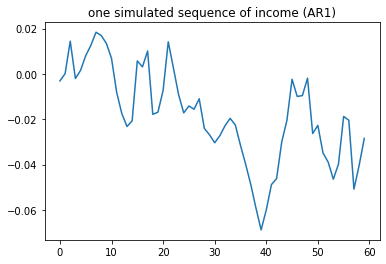

In [7]:
## simulate ar1 data 

plt.subplot(1,1,1)
plt.title('one simulated sequence of income (AR1)')
plt.plot(simulated_data1)

Text(0.5, 1.0, 'Distribution of income over time')

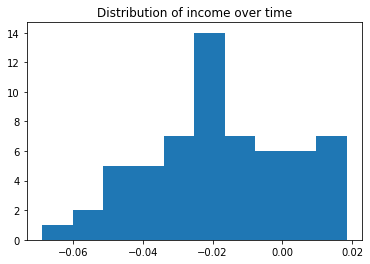

In [8]:
dist = plt.hist(simulated_data1)
plt.title('Distribution of income over time')

In [9]:
simulated_data_pop = one.SimulatePop()

Text(0.5, 1.0, 'Unconditional distribution')

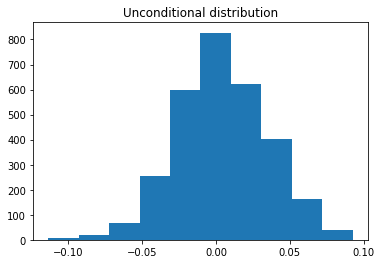

In [10]:
dist_pop = plt.hist(simulated_data_pop.flatten())
plt.title('Unconditional distribution')

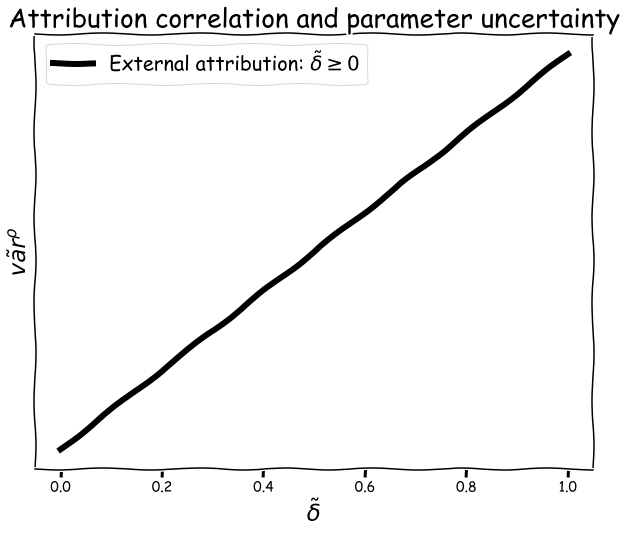

In [14]:
## correlation and perceived risks 

n_grid = 20
corrs = np.linspace(0,1,n_grid)
tilde_var_paras = np.empty(n_grid)
hat_var_paras = np.empty(n_grid)
y_now = 2
sigma2 = one.sigma**2


for i,corr in enumerate(corrs):
    tilde_var_paras[i] = one.PredictVar(y_now = y_now,
                                        corr = corr,
                                        sigma2 = sigma2)
with plt.xkcd():
    plt.figure(figsize = figsize)
    plt.plot(corrs,
            tilde_var_paras,
            'k-',
            lw = lw,
            label =r'External attribution: $\tilde{\delta} \geq 0$')
    #plt.axhline(tilde_var_paras[0],
    #            lw = lw,
    #            label =r'Internal attribution: $\tilde{\delta} = 0$')
    plt.xlabel(r'$\tilde \delta$',
               fontsize = fontsize)
    plt.ylabel(r'$\tilde{var}^\rho}$',
               fontsize = fontsize)
    #plt.text(0.5,0.4,
    #         r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}ny^2_{i,t} + 1] \tilde{\sigma}^2$',
    #         fontsize = fontsize, 
    #         color='blue', 
    #         horizontalalignment="left")
    #plt.annotate("x", xy=(px, py), 
    #             xytext=(px-1.3,py+0.5),
    #             color="green",
    #             weight="heavy", 
    #             fontsize= 14,
    #             arrowprops={"facecolor": "lightgreen"})
    #plt.grid(True)
    #plt.xticks([])
    plt.yticks([])
    plt.legend(loc = 0,
               fontsize = legendsize)
    plt.title('Attribution correlation and parameter uncertainty',
             fontsize = titlesize)
    plt.savefig('../Graphs/theory/corr_var.jpg')

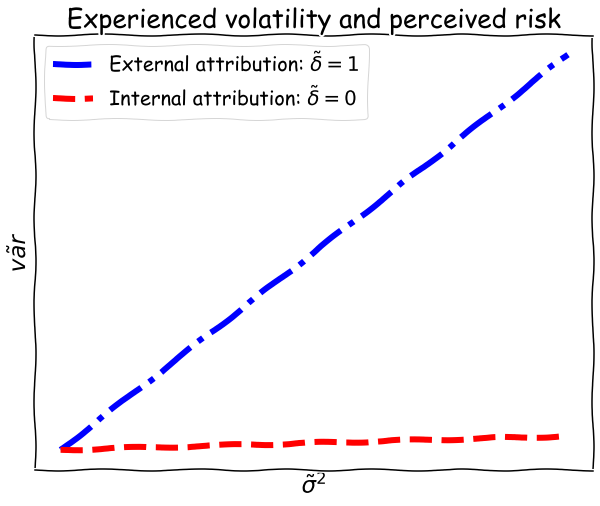

In [12]:
n_grid = 20
simga2s = np.linspace(0,2*one.sigma,n_grid)
tilde_var_paras = np.empty(n_grid)
hat_var_paras = np.empty(n_grid)
y_now = 2


for i,sigma2 in enumerate(simga2s):
    tilde_var_paras[i] = one.PredictVar(y_now = y_now,
                                        corr = 1,
                                        sigma2 = sigma2)
    hat_var_paras[i] = one.PredictVar(y_now = y_now,
                                      corr = 0,
                                      sigma2 = sigma2)
with plt.xkcd():
    plt.figure(figsize = figsize)
    plt.plot(simga2s,
            tilde_var_paras,
            'b-.',
            lw = lw,
            label =r'External attribution: $\tilde \delta = 1$')
    plt.plot(simga2s,
            hat_var_paras,
            'r--',
            lw = lw,
            label =r'Internal attribution: $ \tilde \delta = 0$')
    plt.xlabel(r'$\tilde \sigma^2$',
               fontsize = fontsize)
    plt.ylabel(r'$\tilde{var}$',
               fontsize = fontsize)
    #plt.text(0,0.15,
    #         r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}ny^2_{i,t} + 1] \tilde{\sigma}^2$',
    #         fontsize = fontsize, 
    #         color='blue', 
    #         horizontalalignment="left")
    #plt.text(0.05,0.001,
    #        r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}y^2_{i,t} + 1] \tilde{\sigma}^2$',
    #         fontsize = fontsize, 
    #         color='red', 
    #         horizontalalignment="left")
    #plt.annotate("x", xy=(px, py), 
    #             xytext=(px-1.3,py+0.5),
    #             color="green",
    #             weight="heavy", 
    #             fontsize= 14,
    #             arrowprops={"facecolor": "lightgreen"})
    #plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc = 0,
               fontsize = legendsize)
    plt.title('Experienced volatility and perceived risk',
             fontsize = titlesize)
    plt.savefig('../Graphs/theory/var_experience_var.jpg')

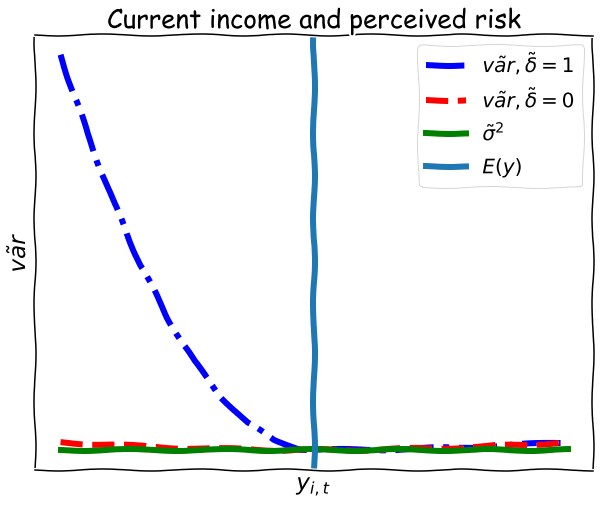

In [13]:
## current income and perceived risks 

n_grid = 20
y_nows = np.linspace(-1,1,n_grid)
tilde_vars = np.empty(n_grid)
hat_vars = np.empty(n_grid)
hat_vars_special = np.empty(n_grid)
sigma2 = one.sigma**2

for i,y_now in enumerate(y_nows):
    corr = one.extrapolate(y_now)
    tilde_vars[i] = one.PredictVar(y_now = y_now,
                                  corr = corr,
                                  sigma2 = sigma2)
    hat_vars[i] = one.PredictVar(y_now = y_now,
                                corr = 0,
                                sigma2 = sigma2)
    hat_vars_special[i] = one.PredictVar(y_now = 0,
                                         corr = 0,
                                         sigma2 = sigma2)
with plt.xkcd():
    plt.figure(figsize = figsize)
    plt.plot(y_nows,
            tilde_vars,
            'b-.',
            lw = lw,
            label =r'$\tilde{var}, \tilde \delta = 1$')
    plt.plot(y_nows,
            hat_vars,
            'r--',
            lw = lw,
            label =r'$\tilde{var}, \tilde \delta = 0$')
    plt.plot(y_nows,
            hat_vars_special,
            'g-',
            lw = lw,
            label =r'$\tilde{\sigma}^2$')
    plt.axvline(0,
                lw = lw,
               label = r'$E(y)$')
    plt.xlabel(r'$y_{i,t}$',
               fontsize = fontsize)
    plt.ylabel(r'$\tilde{var}$',
               fontsize = fontsize)
    #plt.text(0,0.013,
    #         r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}ny^2_{i,t} + 1] \tilde{\sigma}^2$',
    #         fontsize = fontsize, 
    #         color='blue', 
    #         horizontalalignment="left")
    #plt.text(0,0.01,
    #         r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}y^2_{i,t} + 1] \tilde{\sigma}^2$',
    #         fontsize = fontsize, 
    #         color='red', 
    #         horizontalalignment="left")
    plt.xticks([])
    plt.yticks([])
    #plt.annotate("x", xy=(px, py), 
    #             xytext=(px-1.3,py+0.5),
    #             color="green",
    #             weight="heavy", 
    #             fontsize= 14,
    #             arrowprops={"facecolor": "lightgreen"})
    plt.grid(True)
    plt.legend(loc = 1,
               fontsize = legendsize)
    plt.title('Current income and perceived risk',
             fontsize = titlesize)
    plt.savefig('../Graphs/theory/var_recent.jpg')

In [14]:
## This is the above chart simulated 
## different attributions and perceived income risks  

"""
times = 10
corrs = np.linspace(0.01,0.99,times)
vars_predict_est = np.empty(times)

for i,corr in enumerate(corrs):
    one.corr = corr
    one.Simulateiid()
    one.shock_type_perceived = 'attribution_biased'
    one.LearnPara(sample = one.simulated_pop,
                 which = 2)
    vars_predict_est[i] = one.var_predict_chg_est

plt.plot(corrs,
        vars_predict_est,
        'r--',
        label = "var (with bias)")
plt.axhline(vars_predict_est[0],
            label = 'var (no bias)')
plt.title('Perceived risks and attributed correlation',
         fontsize = 15)
plt.xlabel(r'$\widehat\delta$',
          fontsize = 15)
plt.ylabel(r'$var$',
          fontsize = 15)
plt.legend(loc = 0)


"""

'\ntimes = 10\ncorrs = np.linspace(0.01,0.99,times)\nvars_predict_est = np.empty(times)\n\nfor i,corr in enumerate(corrs):\n    one.corr = corr\n    one.Simulateiid()\n    one.shock_type_perceived = \'attribution_biased\'\n    one.LearnPara(sample = one.simulated_pop,\n                 which = 2)\n    vars_predict_est[i] = one.var_predict_chg_est\n\nplt.plot(corrs,\n        vars_predict_est,\n        \'r--\',\n        label = "var (with bias)")\nplt.axhline(vars_predict_est[0],\n            label = \'var (no bias)\')\nplt.title(\'Perceived risks and attributed correlation\',\n         fontsize = 15)\nplt.xlabel(r\'$\\widehat\\delta$\',\n          fontsize = 15)\nplt.ylabel(r\'$var$\',\n          fontsize = 15)\nplt.legend(loc = 0)\n\n\n'

In [15]:
## simple attribution function
"""
chgs = np.linspace(-1,1,200)
corrs = one.extrapolate(chgs,
                       how = 'by_sign')

plt.title('Attribution bias with no extrapolation')
plt.plot(chgs,
         corrs,
         'r-',
         lw = 3,
        label = r'$\tilde \delta_{i}$')
plt.axhline(0,
            lw = 3,
           label =r'$\hat \delta_{i}$')
plt.legend(loc = 0,
           fontsize = 15)
plt.xlabel(r'$\Delta y_{i,t}$',
          fontsize = 15)
plt.ylabel(r'$\hat \delta_{i,t}$',
          fontsize = 15)
          
"""

"\nchgs = np.linspace(-1,1,200)\ncorrs = one.extrapolate(chgs,\n                       how = 'by_sign')\n\nplt.title('Attribution bias with no extrapolation')\nplt.plot(chgs,\n         corrs,\n         'r-',\n         lw = 3,\n        label = r'$\tilde \\delta_{i}$')\nplt.axhline(0,\n            lw = 3,\n           label =r'$\\hat \\delta_{i}$')\nplt.legend(loc = 0,\n           fontsize = 15)\nplt.xlabel(r'$\\Delta y_{i,t}$',\n          fontsize = 15)\nplt.ylabel(r'$\\hat \\delta_{i,t}$',\n          fontsize = 15)\n          \n"

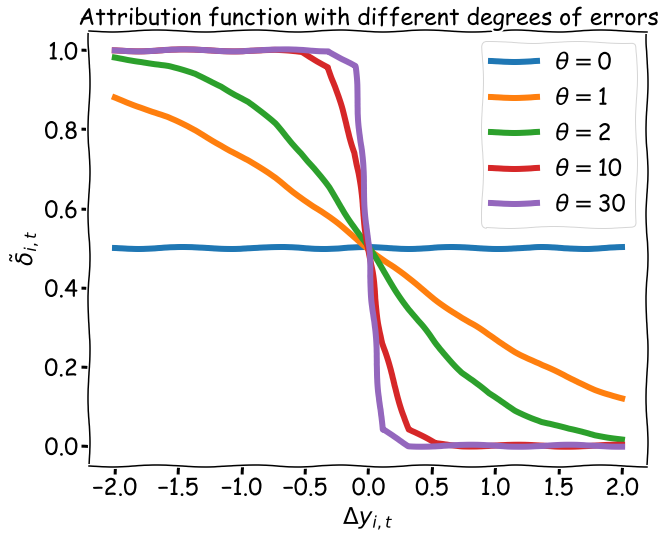

In [30]:
## extrapolative attribution function

chgs = np.linspace(-2,2,20)

thetas = np.array([0,1,2,10,30])

with plt.xkcd():
    plt.figure(figsize = figsize)
    for theta in thetas:
        one.theta = theta
        corrs = one.extrapolate(chgs)
        plt.plot(chgs,
                 corrs,
                 lw = lw,
                 label = r'$\theta =$'+str(theta))
        #plt.axhline(0,
        #           label =r'$\hat \delta_{i}$')
        plt.legend(loc = 0,
                  fontsize = fontsize)
    plt.xlabel(r'$\Delta y_{i,t}$',
               fontsize = fontsize)
    plt.ylabel(r'$\tilde \delta_{i,t}$',
               fontsize = fontsize)
    plt.title('Attribution function with different degrees of errors',
             fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.savefig('../Graphs/theory/theta_corr.jpg')

In [17]:
## for iid
"""
## Estimate the model with the correctly specified model of i.i.d shock
one.shock_type_perceived = 'iid'
coeffs_est_iid,coef_vars_est_iid,sigma2s_est_iid,var_predict_chg_est_iid = one.LearnParafromExperience()
var_predict_chg_est_iid_mean = np.nanmean(var_predict_chg_est_iid)

est_iid = {'coef_est':np.nanmean(coeffs_est_iid),
          'coef_var_est':np.nanmean(coef_vars_est_iid),
          'sigma2s_est':np.nanmean(sigma2s_est_iid),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_iid)}

## for cluster 
one.shock_type_perceived = 'cluster'
coeffs_est_cl,coef_vars_est_cl,sigma2s_est_cl,var_predict_chg_est_cl = one.LearnParafromExperience()


est_cl = {'coef_est':np.nanmean(coeffs_est_cl),
          'coef_var_est':np.nanmean(coef_vars_est_cl),
          'sigma2s_est':np.nanmean(sigma2s_est_cl),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_cl)}

## for serial_correlate 
one.shock_type_perceived = 'serial_correlate'
coeffs_est_sc,coef_vars_est_sc,sigma2s_est_sc,var_predict_chg_est_sc = one.LearnParafromExperience()

est_sc = {'coef_est':np.nanmean(coeffs_est_sc),
          'coef_var_est':np.nanmean(coef_vars_est_sc),
          'sigma2s_est':np.nanmean(sigma2s_est_sc),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_sc)}

## for attribution biased

one.shock_type_perceived = 'attribution_biased'
coeffs_est_ab,coef_vars_est_ab,sigma2s_est_ab,var_predict_chg_est_ab = one.LearnParafromExperience()

est_ab = {'coef_est':np.nanmean(coeffs_est_ab),
          'coef_var_est':np.nanmean(coef_vars_est_ab),
          'sigma2s_est':np.nanmean(sigma2s_est_ab),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_ab)}


## for attribution biased by size 

one.shock_type_perceived = 'extrapolative_attribution_biased'
coeffs_est_eab,coef_vars_est_eab,sigma2s_est_eab,var_predict_chg_est_eab = one.LearnParafromExperience()

est_eab = {'coef_est':np.nanmean(coeffs_est_eab),
          'coef_var_est':np.nanmean(coef_vars_est_eab),
          'sigma2s_est':np.nanmean(sigma2s_est_eab),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_eab)}

idx = ['iid','cluster','serial correlation','attribution biased','ex_attribution biased']

ests = pd.DataFrame.from_dict([est_iid, 
                               est_cl,
                               est_sc,
                               est_ab,
                              est_eab])
ests.index = idx
"""

"\n## Estimate the model with the correctly specified model of i.i.d shock\none.shock_type_perceived = 'iid'\ncoeffs_est_iid,coef_vars_est_iid,sigma2s_est_iid,var_predict_chg_est_iid = one.LearnParafromExperience()\nvar_predict_chg_est_iid_mean = np.nanmean(var_predict_chg_est_iid)\n\nest_iid = {'coef_est':np.nanmean(coeffs_est_iid),\n          'coef_var_est':np.nanmean(coef_vars_est_iid),\n          'sigma2s_est':np.nanmean(sigma2s_est_iid),\n          'var_predict_chg_est':np.nanmean(var_predict_chg_est_iid)}\n\n## for cluster \none.shock_type_perceived = 'cluster'\ncoeffs_est_cl,coef_vars_est_cl,sigma2s_est_cl,var_predict_chg_est_cl = one.LearnParafromExperience()\n\n\nest_cl = {'coef_est':np.nanmean(coeffs_est_cl),\n          'coef_var_est':np.nanmean(coef_vars_est_cl),\n          'sigma2s_est':np.nanmean(sigma2s_est_cl),\n          'var_predict_chg_est':np.nanmean(var_predict_chg_est_cl)}\n\n## for serial_correlate \none.shock_type_perceived = 'serial_correlate'\ncoeffs_est_sc,coe

In [18]:
#ests

### Experienced volatility and perceived risk

In [19]:
## a help function that takes the common elements of two arrays that are not nan
def notnanboth(xx,yy):
    xisnan = np.isnan(xx)
    yisnan = np.isnan(yy)
    bothnotnan = np.logical_and(~xisnan,~yisnan)
    return xx[bothnotnan],yy[bothnotnan]

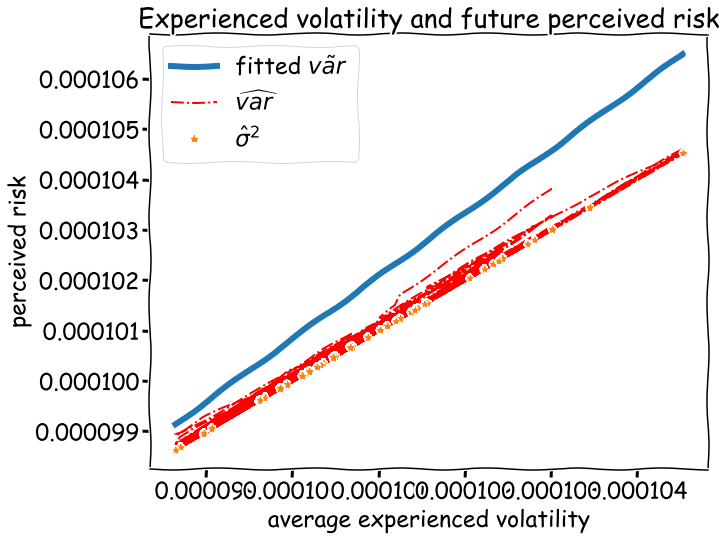

In [20]:
## simulate a historical sample populated by agents at different ages 

## attribution bias 
one.shock_type_perceived = 'iid' #extrapolative_attribution_biased
coeffs_est_iid,coef_vars_est_iid,sigma2s_est_iid,var_predict_chg_est_iid = one.LearnParafromExperience()

ages = one.ages_pop_sim.flatten()
sigma2s = sigma2s_est_iid.flatten()
coef_vars_iid = coef_vars_est_iid.flatten()
vars_predict_chg_iid = var_predict_chg_est_iid.flatten()
av_past = one.av_past.flatten()
recent = one.recent.flatten()

## attribution bias 

one.shock_type_perceived = 'extrapolative_attribution_biased' #extrapolative_attribution_biased
coeffs_est_ab,coef_vars_est_ab,sigma2s_est_ab,var_predict_chg_est_ab = one.LearnParafromExperience()
vars_predict_chg_ab = var_predict_chg_est_ab.flatten()
coef_vars_est_ab = coef_vars_est_ab.flatten()

## average experienced volatility and the perceived income risk

with plt.xkcd():
    fig = plt.figure(figsize = figsize)
    #plt.plot(sigma2s,
    #         vars_predict_chg_ab,'v',
    #         label = r'$\tilde{var}$')

    sigma2s_,vars_predict_chg_ab_ = notnanboth(sigma2s,
                                               vars_predict_chg_ab)

    ## fit a line 
    a, b = np.polyfit(sigma2s_, 
                      vars_predict_chg_ab_,
                      deg = 1)
    sigma2s_uq = np.unique(sigma2s)

    plt.plot(sigma2s_uq,
             a*sigma2s_uq+ b,'-',
             lw = lw,
             label = r'fitted $\tilde{var}$')

    plt.plot(sigma2s,
             vars_predict_chg_iid,'r-.',
             label = r'$\widehat{var}$')

    plt.plot(sigma2s,
             sigma2s,'*',
             label = r'$\hat \sigma^2$')

    #plt.axhline(one.var_predict_chg,
    #            color ='red',
    #            label =r'$\sigma^2$')

    plt.title('Experienced volatility and future perceived risk',
             fontsize = titlesize)
    plt.xlabel('average experienced volatility',
               fontsize = fontsize)
    plt.ylabel('perceived risk',fontsize = fontsize)
    plt.legend(loc = 0,fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.savefig('../Graphs/theory/var_experience_var_sim.jpg')

The figure illustrates the correlation between individual's experienced volatility and future perceived income risks. Blue stars represent the scenario without attribution errors, while the orange dots represent perceived risks under attribution errors. 

We can see individuals that have had bad income realizations extrapolate the average size of past shocks into future income risks, even though the past income shocks are the best estimate of future income risks according to the underlying model. 

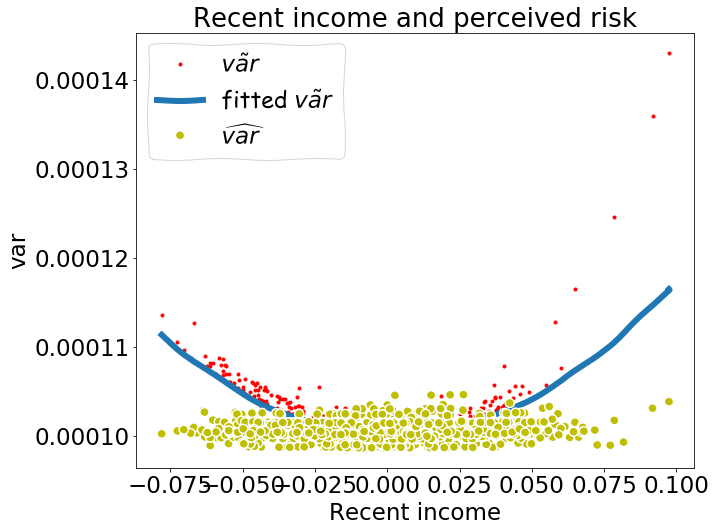

In [21]:
## simulation plot

fig = plt.figure(figsize = figsize)
plt.plot(recent,
         vars_predict_chg_ab,'r.',
         label = r'$\tilde{var}$')

## fit a line
recent_,vars_predict_chg_ab_ = notnanboth(recent,
                                          vars_predict_chg_ab)

a, b, c= np.polyfit(recent_, 
                    vars_predict_chg_ab_,
                    deg = 2)
recent_uq = np.unique(recent)

with plt.xkcd():
    plt.plot(recent_uq,
             a*recent_uq**2+b*recent_uq+c,'-',
             lw = lw,
             label = r'fitted $\tilde{var}$')
    plt.plot(recent,
             vars_predict_chg_iid,'yo',
             label = r'$\widehat{var}$')
    plt.title('Recent income and perceived risk',
             fontsize = titlesize)
    plt.xlabel('Recent income',
               fontsize = fontsize)
    plt.ylabel('var',fontsize = fontsize)
    plt.legend(loc = 0,fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.savefig('../Graphs/theory/var_recent_sim.jpg')

### Age and perceived risks

In [22]:
#plt.plot(one.ages_pop_sim[:,35],
#         var_predict_chg_est1[:,35],'*')
#plt.title('Perceived risks by age at a given time')
#plt.xlabel('age',fontsize = 15)
#plt.ylabel('var',fontsize = 15)

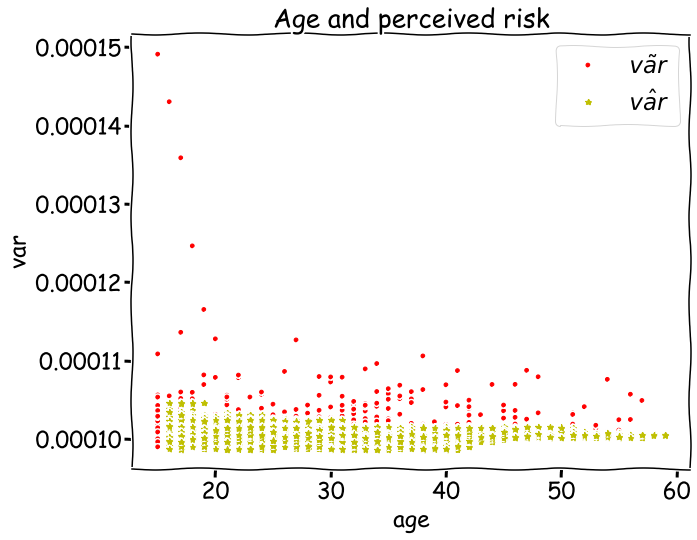

In [23]:
## fit a line
ages_,vars_predict_chg_ab_ = notnanboth(ages,
                                        vars_predict_chg_ab)

a, b,c= np.polyfit(ages_,
                   vars_predict_chg_ab_,
                   deg = 2)

ages_uq = np.unique(ages)

with plt.xkcd():
    fig = plt.figure(figsize = figsize)
   #plt.plot(ages_uq,
   #          a*ages_uq**2+ages_uq*b+c,
   #          'b-',
   #         label =r'$\tilde{var}$')
    plt.plot(ages,vars_predict_chg_ab,
             'r.',
            label =r'$\tilde{var}$')
    plt.plot(ages,vars_predict_chg_iid,
             'y*',
            label =r'$\hat{var}$')
    plt.title('Age and perceived risk',
             fontsize = titlesize)
    plt.xlabel('age',fontsize = fontsize)
    plt.ylabel('var',fontsize = fontsize)
    plt.legend(loc = 0,fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.savefig('../Graphs/theory/var_age_sim.jpg')

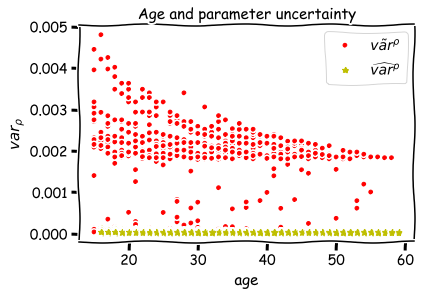

In [24]:
with plt.xkcd():
    plt.plot(ages,
             coef_vars_est_ab,
             'r.',
            label = r'$\tilde{var}^{\rho}$')
    plt.plot(ages,
             coef_vars_iid,
             'y*',
             label = r'$\widehat{var}^{\rho}$')
    plt.title('Age and parameter uncertainty',
             fontsize = 15)
    plt.xlabel('age',fontsize = 15)
    plt.ylabel(r'$var_\rho$',fontsize = 15)
    plt.legend(loc = 0)

In [25]:
#plt.plot(ages,sigma2s,'*')
#plt.xlabel('age',fontsize = 15)
#plt.ylabel(r'$\hat \sigma^2$',fontsize = 15)

In [26]:
## plot average past income changes and perceived risks with aggregate risks

one.shock_type = 'correlated'  ## reset the true model to be with aggregate the risks
one.SimulatePop()


one.shock_type_perceived = 'iid' #extrapolative_attribution_biased
coeffs_est_iid_ag,coef_vars_est_iid_ag,sigma2s_est_iid_ag,var_predict_chg_est_iid_ag = one.LearnParafromExperience()

##  cross-sectional average
vars_predict_chg_iid_av = np.nanmean(var_predict_chg_est_iid_ag,axis = 0)
changes_iid_ag_av =  np.nanmean(one.changes,axis = 0)  ## same for the below 

one.shock_type_perceived = 'extrapolative_attribution_biased' #extrapolative_attribution_biased
coeffs_est_eab_ag,coef_vars_est_eab_ag,sigma2s_est_eab_ag,var_predict_chg_est_eab_ag = one.LearnParafromExperience()

##  cross-sectional average
vars_predict_chg_eab_av = np.nanmean(var_predict_chg_est_eab_ag,axis = 0)
changes_eab_ag_av = np.nanmean(one.changes,axis = 0)

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: overflow encountered in exp
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


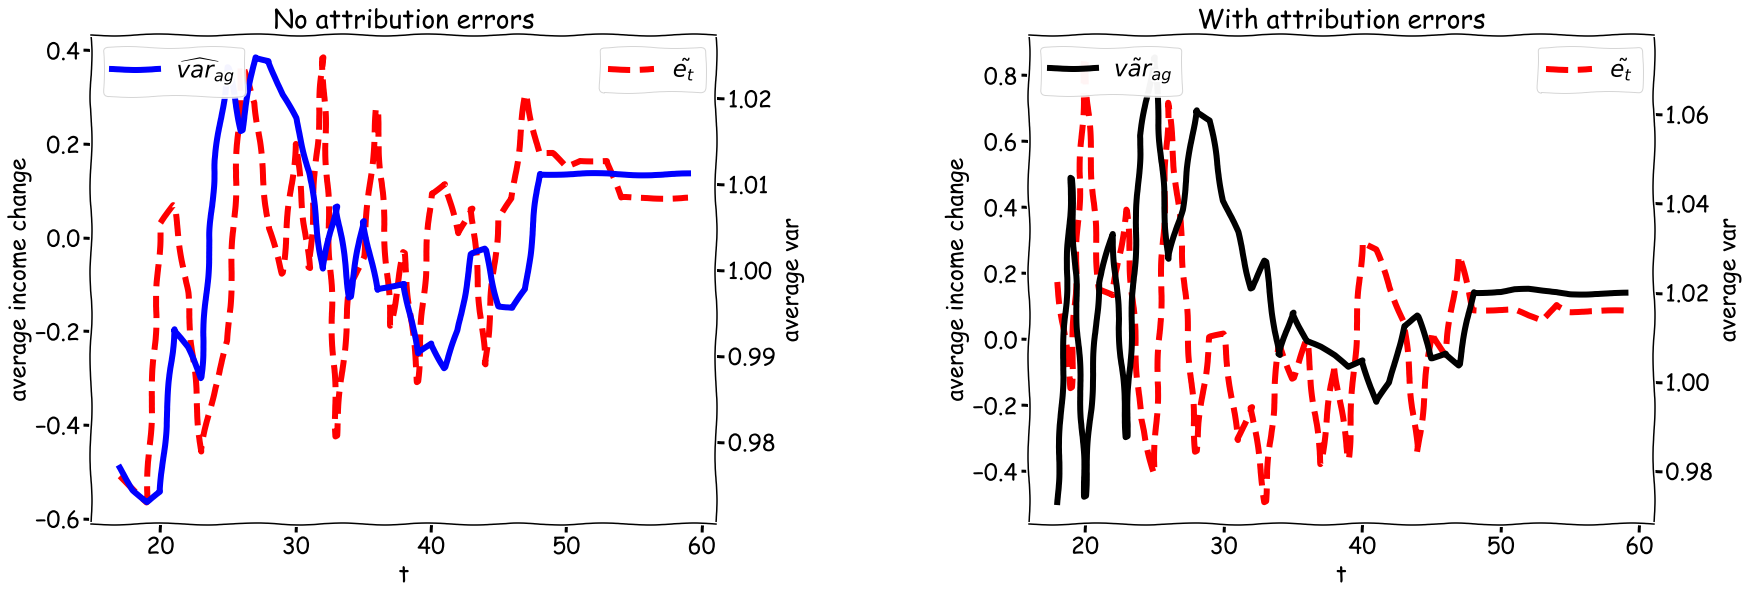

In [27]:
## plot
with plt.xkcd():
    fig, ax = plt.subplots(1,2,figsize = (28,9))
    fig.subplots_adjust(wspace = 0.5)
    ax2 = ax[0].twinx()
    ax[0].plot(changes_iid_ag_av,
               'r--',
               lw = lw,
            label = r'$\tilde{e_{t}}$')
    ax2.plot(vars_predict_chg_iid_av,
             'b-',
             lw = lw,
             label = r'$\widehat{var}_{ag}$')
    ax[0].set_xlabel('t',
               fontsize = fontsize)
    ax[0].set_ylabel('average income change',
                     fontsize = fontsize)
    ax2.set_ylabel('average var',fontsize = fontsize)
    ax[0].legend(loc = 1,fontsize = fontsize)
    ax2.legend(loc = 2,fontsize = fontsize)
    ## ticklabels 
    ax[0].tick_params(axis='x', labelsize= fontsize)
    ax[0].tick_params(axis='y', labelsize= fontsize)
    ax2.tick_params(axis='x', labelsize= fontsize)
    ax2.tick_params(axis='y', labelsize= fontsize)
    ax[0].set_title('No attribution errors',fontsize = titlesize)

    ax3 = ax[1].twinx()
    ax[1].plot(changes_eab_ag_av,
           'r--',
               lw = lw,
            label = r'$\tilde{e_{t}}$')
    ax3.plot(vars_predict_chg_eab_av,
             'k-',
             lw = lw,
             label = r'$\tilde{var}_{ag}$')
    ax[1].set_xlabel('t',
                     fontsize = fontsize)
    ax[1].set_ylabel('average income change',
                    fontsize = fontsize)
    ax3.set_ylabel('average var',fontsize = fontsize)
    ax[1].legend(loc = 1,fontsize = fontsize)
    ax3.legend(loc = 2,fontsize = fontsize)
    ## tick labels 
    ax[1].tick_params(axis='x', labelsize= fontsize)
    ax[1].tick_params(axis='y', labelsize= fontsize)
    ax3.tick_params(axis='x', labelsize= fontsize)
    ax3.tick_params(axis='y', labelsize= fontsize)
    ax[1].set_title('With attribution errors',fontsize = titlesize)
    plt.savefig('../Graphs/theory/var_recent_change_sim.jpg')

In [28]:
## aggregate risks versus indiosyncratic risks we

### only idiosyncratic risks
one.shock_type_perceived = 'extrapolative_attribution_biased' #extrapolative_attribution_biased common for both 

## shocks take either iid or aggregate  
one.shock_type = 'iid'  ## reset the true model to be with aggregate the risks
one.SimulatePop()

coeffs_est_eab_id,coef_vars_est_eab_id,sigma2s_est_eab_id,var_predict_chg_est_eab_id = one.LearnParafromExperience()

##  cross-sectional average
vars_predict_chg_eab_id_av = np.nanmean(var_predict_chg_est_eab_id,axis = 0)
changes_eab_id_av =  np.nanmean(one.changes,axis = 0)

### aggregate risk
one.shock_type = 'correlated'  ## reset the true model to be with aggregate the risks
one.SimulatePop()

coeffs_est_eab_ag,coef_vars_est_eab_ag,sigma2s_est_eab_ag,var_predict_chg_est_eab_ag = one.LearnParafromExperience()

##  cross-sectional average
vars_predict_chg_eab_av = np.nanmean(var_predict_chg_est_eab_ag,axis = 0)
changes_eab_ag_av =  np.nanmean(one.changes,axis = 0)

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: overflow encountered in exp
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


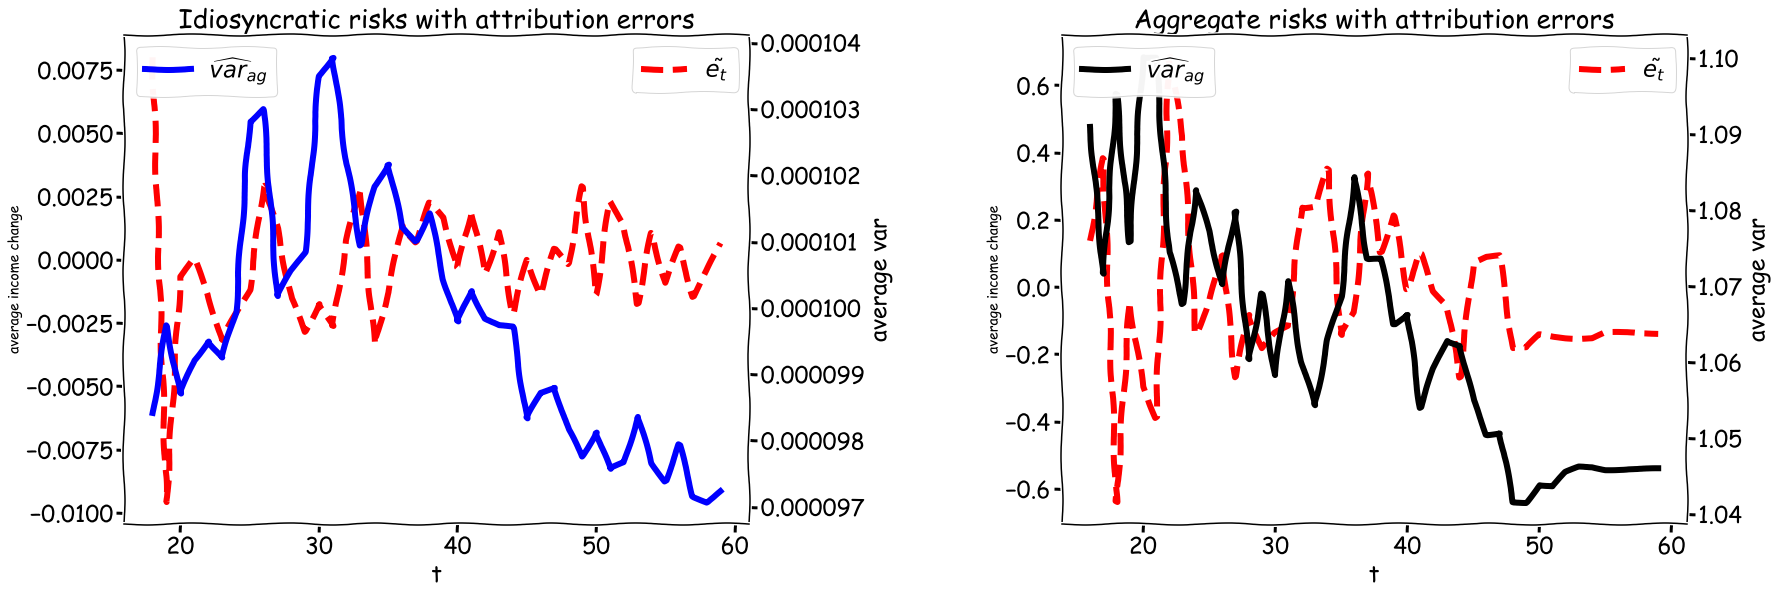

In [29]:
## plot idiosyncratic risks and aggregate risks 
with plt.xkcd():
    fig, ax = plt.subplots(1,2,figsize = (28,9))
    fig.subplots_adjust(wspace = 0.5)
    ax2 = ax[0].twinx()
    ax[0].plot(changes_eab_id_av,
           'r--',
            lw = lw,
            label = r'$\tilde{e_{t}}$')
    ax2.plot(vars_predict_chg_eab_id_av,
             'b-',
             lw = lw,
             label = r'$\widehat{var}_{ag}$')
    ax[0].set_xlabel('t',
               fontsize = fontsize)
    ax[0].set_ylabel('average income change')
    ax2.set_ylabel('average var',fontsize = fontsize)
    ax[0].legend(loc = 1,fontsize = fontsize)
    ax2.legend(loc = 2,fontsize = fontsize)
    ## tick labels 
    ax[0].tick_params(axis='x', labelsize= fontsize)
    ax[0].tick_params(axis='y', labelsize= fontsize)
    ax2.tick_params(axis='x', labelsize= fontsize)
    ax2.tick_params(axis='y', labelsize= fontsize)
    ax[0].set_title('Idiosyncratic risks with attribution errors',fontsize = titlesize)

    ax3 = ax[1].twinx()
    ax[1].plot(changes_eab_ag_av,
           'r--',
            lw = lw,
            label = r'$\tilde{e_{t}}$')
    ax3.plot(vars_predict_chg_eab_av,
             'k-',
             lw = lw,
             label = r'$\widehat{var}_{ag}$')
    ax[1].set_ylabel('average income change')
    ax3.set_ylabel('average var',fontsize = fontsize)
    ax[1].set_xlabel('t',
                     fontsize = fontsize)
    ax[1].legend(loc = 1,fontsize = fontsize)
    ax3.legend(loc = 2,fontsize = fontsize)
    ## tick labels 
    ax[1].tick_params(axis='x', labelsize= fontsize)
    ax[1].tick_params(axis='y', labelsize= fontsize)
    ax3.tick_params(axis='x', labelsize= fontsize)
    ax3.tick_params(axis='y', labelsize= fontsize)
    ax[1].set_title('Aggregate risks with attribution errors',fontsize = titlesize)
    plt.savefig('../Graphs/theory/var_recent_change_sim2.jpg')